# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.43KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

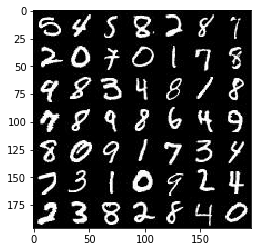

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

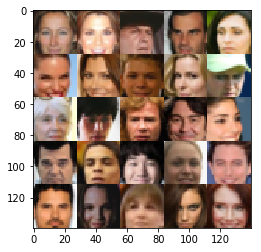

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(dtype = tf.float32, shape = [None, image_height, image_width, image_channels], name = 'real_inputs')
    generation_seeds = tf.placeholder(dtype = tf.float32, shape = [None, z_dim], name = 'generation_seeds')
    learning_rate = tf.placeholder(dtype = tf.float32, name = 'learning_rate')

    return real_inputs, generation_seeds, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse = False, alpha = 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h, w, c = 28, 28, 4  # Input
                
        disc_flow = tf.layers.conv2d(
            inputs = images, 
            filters = 128, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same')
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, seed = 1.1)
        
        h, w, c = 14, 14, 128
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 64, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same') 
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = True)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, seed = 1.2)
        
        h, w, c = 7, 7, 64
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 32, 
            kernel_size = 3, 
            strides = 1,
            padding = 'same')
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = True)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, seed = 1.3)
        
        h, w, c = 7, 7, 32
        
        disc_flow = tf.reshape(tensor = disc_flow, shape = [-1, h * w * c])
        disc_flow = tf.layers.dense(
            inputs = disc_flow, 
            units = 1)
        output = tf.tanh(disc_flow)
        
    return output, disc_flow

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse = not is_train):
    
        h, w, c = 7, 7, 16  # Start

        gen_flow = tf.layers.dense(
            inputs = z,
            units = h * w * c)
        gen_flow = tf.reshape(
            tensor = gen_flow, 
            shape = [-1, h, w, c])
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)

        h, w, c = 7, 7, 16

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 32, 
            kernel_size = 3, 
            strides = 1, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, seed = 1.1)

        h, w, c = 7, 7, 32

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 64, 
            kernel_size = 3, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, seed = 1.2)
        
        h, w, c = 14, 14, 64
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 128, 
            kernel_size = 5, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, seed = 1.3)
        
        h, w, c = 28, 28, 128
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = out_channel_dim, 
            kernel_size = 7, 
            strides = 1, 
            padding = 'same')
        
        h, w, c = 28, 28, out_channel_dim
        
        out = tf.tanh(gen_flow)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_out = generator(z = input_z, out_channel_dim = out_channel_dim, is_train = True, alpha = alpha)
    d_real_out, d_real_layer = discriminator(images = input_real, reuse = False, alpha = alpha)
    d_fake_out, d_fake_layer = discriminator(images = g_out, reuse = True, alpha = alpha)
    
    g_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.ones_like(d_fake_out)))
    
    d_real_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_real_layer, 
            labels = tf.ones_like(d_real_out)))
    d_fake_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.zeros_like(d_fake_out)))

    d_loss = d_real_loss + d_fake_loss

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    tf.reset_default_graph()
    
    real_inputs, generation_seeds, lr = model_inputs(
        image_width = data_shape[1], 
        image_height =  data_shape[2], 
        image_channels = data_shape[3], 
        z_dim = z_dim)
    
    d_loss, g_loss = model_loss(
        input_real = real_inputs, 
        input_z = generation_seeds, 
        out_channel_dim = data_shape[3], 
        alpha = 0.01)

    g_opt, d_opt = model_opt(
        d_loss = d_loss, 
        g_loss = g_loss, 
        learning_rate = lr, 
        beta1 = beta1)    

    steps = 0
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for x in get_batches(batch_size):
                
                steps += 1

                z = np.random.uniform(low = -1, high = 1, size = [batch_size, z_dim])

                feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate}
                
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})

                if steps % 16 == 0:
                    
                    d_train_loss = d_loss.eval({generation_seeds: z, real_inputs: x})
                    g_train_loss = g_loss.eval({generation_seeds: z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "D Loss: {:.4f}...".format(d_train_loss),
                          "G Loss: {:.4f}".format(g_train_loss))
                    
                if steps % 128 == 0:
                    
                    show_generator_output(
                        sess = sess, 
                        n_images = 8, 
                        input_z = generation_seeds, 
                        out_channel_dim = data_shape[3], 
                        image_mode = data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... D Loss: 0.0240... G Loss: 5.2286
Epoch 1/2... D Loss: 0.0477... G Loss: 4.0619
Epoch 1/2... D Loss: 0.0064... G Loss: 5.6980
Epoch 1/2... D Loss: 0.0049... G Loss: 6.0515
Epoch 1/2... D Loss: 0.0027... G Loss: 6.9202
Epoch 1/2... D Loss: 0.0038... G Loss: 6.0912
Epoch 1/2... D Loss: 0.0716... G Loss: 3.6704
Epoch 1/2... D Loss: 0.0098... G Loss: 5.6414


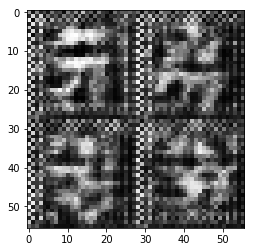

Epoch 1/2... D Loss: 0.0099... G Loss: 6.1168
Epoch 1/2... D Loss: 0.0022... G Loss: 14.3529
Epoch 1/2... D Loss: 0.0042... G Loss: 8.4511
Epoch 1/2... D Loss: 0.0023... G Loss: 17.9207
Epoch 1/2... D Loss: 0.0065... G Loss: 5.9826
Epoch 1/2... D Loss: 0.0464... G Loss: 4.3438
Epoch 1/2... D Loss: 0.0239... G Loss: 5.1208
Epoch 1/2... D Loss: 0.0185... G Loss: 5.4677


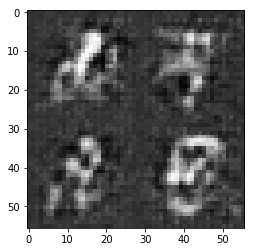

Epoch 1/2... D Loss: 0.0255... G Loss: 5.1355
Epoch 1/2... D Loss: 0.0238... G Loss: 4.2818
Epoch 1/2... D Loss: 0.0023... G Loss: 8.7200
Epoch 1/2... D Loss: 0.0197... G Loss: 5.5485
Epoch 1/2... D Loss: 0.0092... G Loss: 6.4801
Epoch 1/2... D Loss: 0.0116... G Loss: 5.6975
Epoch 1/2... D Loss: 0.0459... G Loss: 4.3348
Epoch 1/2... D Loss: 0.0295... G Loss: 6.6837


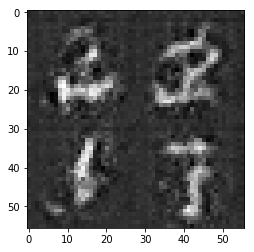

Epoch 1/2... D Loss: 0.0183... G Loss: 5.4903
Epoch 1/2... D Loss: 0.0060... G Loss: 6.7634
Epoch 1/2... D Loss: 0.0407... G Loss: 4.0123
Epoch 1/2... D Loss: 0.0038... G Loss: 7.3528
Epoch 1/2... D Loss: 0.0278... G Loss: 6.5557
Epoch 1/2... D Loss: 0.0078... G Loss: 6.0526
Epoch 1/2... D Loss: 0.0100... G Loss: 6.0021
Epoch 1/2... D Loss: 0.0103... G Loss: 6.4547


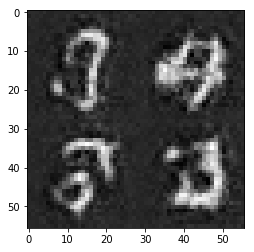

Epoch 1/2... D Loss: 0.0588... G Loss: 3.7660
Epoch 1/2... D Loss: 0.0221... G Loss: 7.0547
Epoch 1/2... D Loss: 0.0028... G Loss: 8.3812
Epoch 1/2... D Loss: 0.0066... G Loss: 6.7086
Epoch 1/2... D Loss: 0.0014... G Loss: 8.1816
Epoch 1/2... D Loss: 0.0032... G Loss: 6.6080
Epoch 1/2... D Loss: 0.0008... G Loss: 10.3150
Epoch 1/2... D Loss: 0.0018... G Loss: 9.6363


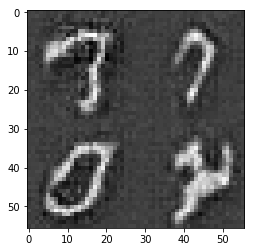

Epoch 1/2... D Loss: 0.2536... G Loss: 2.4908
Epoch 1/2... D Loss: 0.0819... G Loss: 3.7105
Epoch 1/2... D Loss: 0.0469... G Loss: 3.8265
Epoch 1/2... D Loss: 0.0354... G Loss: 4.7440
Epoch 1/2... D Loss: 0.0280... G Loss: 4.8543
Epoch 1/2... D Loss: 0.0300... G Loss: 4.4140
Epoch 1/2... D Loss: 0.0393... G Loss: 4.9449
Epoch 1/2... D Loss: 0.0316... G Loss: 4.6014


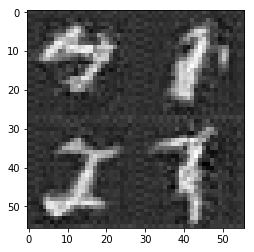

Epoch 1/2... D Loss: 0.0219... G Loss: 5.0400
Epoch 1/2... D Loss: 0.0184... G Loss: 6.6082
Epoch 1/2... D Loss: 0.0291... G Loss: 5.1478
Epoch 1/2... D Loss: 0.0145... G Loss: 6.4816
Epoch 1/2... D Loss: 0.0184... G Loss: 5.5111
Epoch 1/2... D Loss: 0.0135... G Loss: 5.7086
Epoch 1/2... D Loss: 0.0044... G Loss: 8.6897
Epoch 1/2... D Loss: 0.0307... G Loss: 5.0838


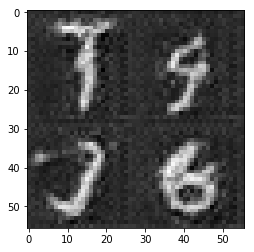

Epoch 1/2... D Loss: 0.0201... G Loss: 5.6244
Epoch 1/2... D Loss: 0.0178... G Loss: 6.2488
Epoch 1/2... D Loss: 0.0161... G Loss: 5.6514
Epoch 1/2... D Loss: 0.0319... G Loss: 5.2333
Epoch 1/2... D Loss: 0.0260... G Loss: 6.8722
Epoch 1/2... D Loss: 0.0290... G Loss: 7.1926
Epoch 1/2... D Loss: 0.0177... G Loss: 7.6134
Epoch 1/2... D Loss: 0.0350... G Loss: 6.7400


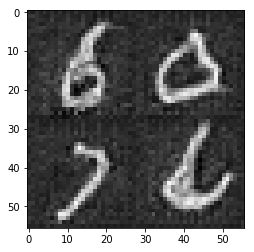

Epoch 1/2... D Loss: 0.0222... G Loss: 5.0845
Epoch 1/2... D Loss: 0.0137... G Loss: 5.8476
Epoch 1/2... D Loss: 0.0115... G Loss: 6.5809
Epoch 1/2... D Loss: 0.0165... G Loss: 5.6915
Epoch 1/2... D Loss: 0.0164... G Loss: 6.3484
Epoch 1/2... D Loss: 0.0088... G Loss: 6.1847
Epoch 1/2... D Loss: 0.0075... G Loss: 7.1622
Epoch 1/2... D Loss: 0.0136... G Loss: 6.1069


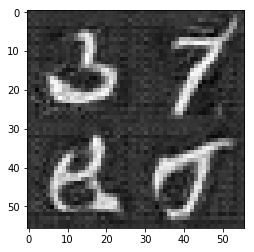

Epoch 1/2... D Loss: 0.0152... G Loss: 6.2889
Epoch 1/2... D Loss: 0.0058... G Loss: 6.9596
Epoch 1/2... D Loss: 0.7338... G Loss: 1.0187
Epoch 1/2... D Loss: 0.0373... G Loss: 5.6560
Epoch 1/2... D Loss: 0.0277... G Loss: 4.4775
Epoch 1/2... D Loss: 0.0368... G Loss: 7.6066
Epoch 1/2... D Loss: 0.0038... G Loss: 7.4674
Epoch 1/2... D Loss: 0.0025... G Loss: 9.6683


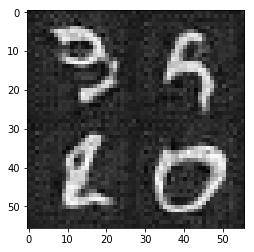

Epoch 1/2... D Loss: 0.0145... G Loss: 6.4418
Epoch 1/2... D Loss: 0.0237... G Loss: 7.0752
Epoch 1/2... D Loss: 0.0139... G Loss: 4.8963
Epoch 1/2... D Loss: 0.0080... G Loss: 5.5804
Epoch 1/2... D Loss: 0.0037... G Loss: 9.2492
Epoch 1/2... D Loss: 0.0013... G Loss: 11.2160
Epoch 1/2... D Loss: 0.0288... G Loss: 5.8499
Epoch 1/2... D Loss: 0.0249... G Loss: 7.1585


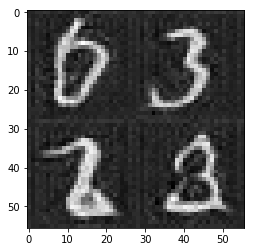

Epoch 1/2... D Loss: 0.0184... G Loss: 5.8195
Epoch 1/2... D Loss: 0.0099... G Loss: 5.8961
Epoch 1/2... D Loss: 0.0173... G Loss: 6.4350
Epoch 1/2... D Loss: 0.0174... G Loss: 5.1131
Epoch 1/2... D Loss: 0.0214... G Loss: 5.2475
Epoch 1/2... D Loss: 0.0125... G Loss: 6.7213
Epoch 1/2... D Loss: 0.0223... G Loss: 4.9623
Epoch 1/2... D Loss: 0.0073... G Loss: 6.5842


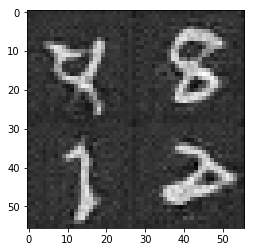

Epoch 1/2... D Loss: 0.0163... G Loss: 8.4233
Epoch 1/2... D Loss: 1.6825... G Loss: 10.5551
Epoch 1/2... D Loss: 0.0305... G Loss: 5.6826
Epoch 1/2... D Loss: 0.0201... G Loss: 5.4651
Epoch 1/2... D Loss: 0.0202... G Loss: 6.2188
Epoch 1/2... D Loss: 0.0238... G Loss: 5.8485
Epoch 1/2... D Loss: 0.0046... G Loss: 6.5894
Epoch 1/2... D Loss: 0.0011... G Loss: 13.4086


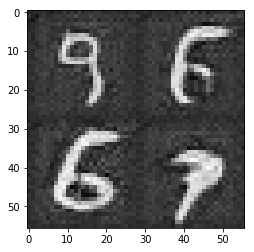

Epoch 1/2... D Loss: 0.0019... G Loss: 15.0321
Epoch 1/2... D Loss: 0.0117... G Loss: 7.2154
Epoch 1/2... D Loss: 0.0029... G Loss: 8.6535
Epoch 1/2... D Loss: 0.0277... G Loss: 5.5409
Epoch 1/2... D Loss: 0.0034... G Loss: 7.5920
Epoch 1/2... D Loss: 0.0253... G Loss: 6.1700
Epoch 1/2... D Loss: 0.0134... G Loss: 6.3207
Epoch 1/2... D Loss: 0.0186... G Loss: 5.3573


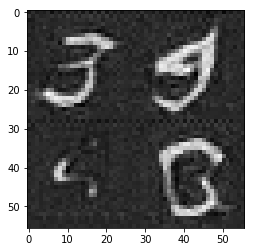

Epoch 1/2... D Loss: 0.0128... G Loss: 5.6685
Epoch 1/2... D Loss: 0.0075... G Loss: 6.4889
Epoch 1/2... D Loss: 0.0190... G Loss: 5.5304
Epoch 1/2... D Loss: 0.0034... G Loss: 9.5533
Epoch 1/2... D Loss: 0.0084... G Loss: 6.9981
Epoch 2/2... D Loss: 0.0058... G Loss: 10.1422
Epoch 2/2... D Loss: 0.0151... G Loss: 5.6315
Epoch 2/2... D Loss: 0.0250... G Loss: 7.3720


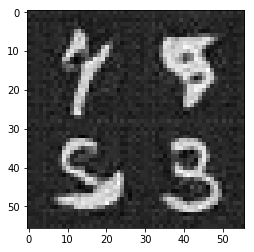

Epoch 2/2... D Loss: 0.0018... G Loss: 10.6147
Epoch 2/2... D Loss: 0.0034... G Loss: 8.6862
Epoch 2/2... D Loss: 0.0038... G Loss: 7.6842


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.66

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.